In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import itertools
from timeit import default_timer as timer
import scipy as sc
import pickle
import scipy.sparse as scs
from functools import lru_cache, cache
import random
import matplotlib as mpl

In [2]:
def boolean_combinations(n):
    return [
        *itertools.product(
            *[[False, True] for _ in range(n)]
    )]

In [3]:
states = boolean_combinations(10)

In [4]:
def el(state):
    e = 0
    e += state[0]*2+state[8]*2+2

    adj_list = [
        (0,1),
        (0,2),
        (1,2),
        (1,3),
        (2,3),
        (2,4),
        (2,5),
        (3,5),
        (4,5),
        (4,6),
        (5,6),
        (5,7),
        (6,7),
        (6,8),
        (6,9),
        (7,9),
        (8,9),
    ]

    wilson_list = [
        (1,0),
        (3,0),
        (3,2),
        (3,4),
        (5,4),
        (7,4),
        (7,6),
        (7,8),
        (9,8)
    ]

    for pair in adj_list:
        e+= state[pair[0]] ^ state[pair[1]]

    for pair in wilson_list:
        e+= not(state[pair[0]] ^ state[pair[1]])
    return e*3/2

In [5]:
plaqs = np.zeros([2**10,10,3], dtype=int) # env, rot, subtype (true = subtype 2, false = subtype 1)

In [6]:
mat_e = np.array([el(state) for state in states])

In [7]:
def reorder(idx, a):
    return a[-idx:] + a[:-idx]

In [8]:
def permcheck(plaq,reference):
    reference = [bool(i) for i in reference]
    reference2 = [not i for i in reference]
    for i in range(6):
        if np.all(np.array(plaq) == np.array(reorder(i, reference))) or np.all(np.array(plaq) == np.array(reorder(i, reference2))):
            return i
        
    return 7

In [9]:
def ident_plaq(plaq):
    outer = plaq[:6]

    if sum(outer)==0 or sum(outer)==6: # env 1
        return np.array([1,1,plaq[5] ^ plaq[6]])
        
    if sum(outer)==1 or sum(outer)==5: # env 2
        rot = permcheck(outer, [1,0,0,0,0,0])
        return np.array([2,rot,plaq[(5+rot)%6] ^ plaq[6]])
    
    if sum(outer)==2 or sum(outer)==4: # env 3, 5 and 7
        rot3 = permcheck(outer, [1,1,0,0,0,0])
        if rot3 != 7:
            return np.array([3,rot3,plaq[(5+rot3)%6] ^ plaq[6]])
        rot5 = permcheck(outer, [1,0,1,0,0,0])
        if rot5 != 7:
            return np.array([5,rot5,plaq[(5+rot5)%6] ^ plaq[6]])
        rot7 = permcheck(outer, [1,0,0,1,0,0])
        if rot7 != 7:
            return np.array([7,rot7,plaq[(5+rot7)%6] ^ plaq[6]])
        
    if sum(outer)==3: # env 4, 6 and 8
        rot4 = permcheck(outer, [1,1,1,0,0,0])
        if rot4 != 7:
            return np.array([4,rot4,plaq[(5+rot4)%6] ^ plaq[6]])
        rot6 = permcheck(outer, [1,0,1,1,0,0])
        if rot6 != 7:
            return np.array([6,rot6,plaq[(5+rot6)%6] ^ plaq[6]])
        rot8 = permcheck(outer, [1,0,1,0,1,0])
        if rot8 != 7:
            return np.array([8,rot8,plaq[(5+rot8)%6] ^ plaq[6]])
        
        



In [10]:
for i in range(2**10):
    s = states[i]
    plaqs[i][0] = ident_plaq([False,s[1],s[2],not(s[3]),not(s[1]),False,s[0]])
    plaqs[i][1] = ident_plaq([False,not(s[0]),s[3],s[2],s[0],False,s[1]])
    plaqs[i][2] = ident_plaq([s[1],s[3],s[5],s[4],not(s[3]),s[0],s[2]])
    plaqs[i][3] = ident_plaq([not(s[0]),not(s[2]),not(s[4]),s[5],s[2],s[1],s[3]])
    plaqs[i][4] = ident_plaq([s[2],s[5],s[6],not(s[7]),not(s[5]),not(s[3]),s[4]])
    plaqs[i][5] = ident_plaq([s[3],not(s[4]),s[7],s[6],s[4],s[2],s[5]])
    plaqs[i][6] = ident_plaq([s[5],s[7],s[9],s[8],not(s[7]),s[4],s[6]])
    plaqs[i][7] = ident_plaq([not(s[4]),not(s[6]),not(s[8]),s[9],s[6],s[5],s[7]])
    plaqs[i][8] = ident_plaq([s[6],s[9],False,False,not(s[9]),not(s[7]),s[8]])
    plaqs[i][9] = ident_plaq([s[7],not(s[8]),False,False,s[8],s[6],s[9]])

In [11]:
mat_m = np.zeros([2**10,2**10])

In [12]:
weights = [-128,32,32,32,-32,-32,-32,32]

In [13]:
np.sum(np.array(states[3]) == np.array(states[2])) == 9

np.True_

In [14]:
for i in range(2**10):
    for j in range(2**10):
        if np.sum(np.array(states[i]) == np.array(states[j])) == 9:
            for k in range(10):
                left = plaqs[i,k]
                right = plaqs[j,k]
                if left[0] == right[0] and left[1] == right[1] and left[2] != right[2]:
                    mat_m[i,j] += weights[right[0]-1]

In [15]:
n=50

g2s = np.linspace(0.5,10,n)

vals = np.empty([n,2**10])

In [16]:
for i in range(n):
    vals[i] = sc.linalg.eigvalsh(g2s[i]*np.diag(mat_e)+mat_m*1/g2s[i])

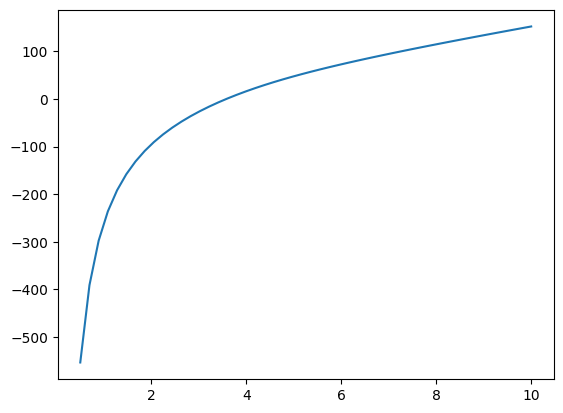

In [17]:
plt.plot(g2s, vals[:,0])

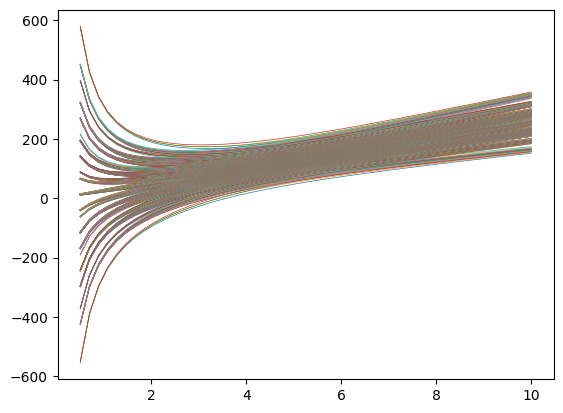

In [18]:
for i in range(2**10):
    plt.plot(g2s, vals[:,i], linewidth=0.5)

In [19]:
def vis_basis(state):
    links = np.empty(34,dtype=bool)
    s = state
    list = [
        (False,s[0],0),
        (False,s[0],0),
        (False,s[1],0),
        (False,s[1],1),
        (s[1],s[0],1),
        (s[0],s[1],0),
        (s[3],s[0],1),
        (s[0],s[2],0),
        (s[1],s[2],0),
        (s[1],s[3],0),
        (s[3],s[2],1),
        (s[2],s[3],0),
        (s[3],s[4],1),
        (s[2],s[4],0),
        (s[2],s[5],0),
        (s[3],s[5],0),
        (s[5],s[4],1),
        (s[4],s[5],0),
        (s[7],s[4],1),
        (s[4],s[6],0),
        (s[5],s[6],0),
        (s[5],s[7],0),
        (s[7],s[6],1),
        (s[6],s[7],0),
        (s[7],s[8],1),
        (s[6],s[8],0),
        (s[6],s[9],0),
        (s[7],s[9],0),
        (s[9],s[8],1),
        (s[8],s[9],0),
        (False,s[8],0),
        (False,s[8],0),
        (False,s[9],0),
        (False,s[9],1),
    ]

    for i in range(34):
        if list[i][2] == 0:
            links[i] = list[i][0] ^ list[i][1]
        else:
            links[i] = not(list[i][0] ^ list[i][1])

    return links

In [20]:
def plotter(link_weights):
    cmap = mpl.colormaps["coolwarm"]
    norm = mpl.colors.Normalize(vmin=0,vmax=1)
    colors = cmap(norm(link_weights))
    fig, ax = plt.subplots()

    starts = np.zeros([34,2])
    ends = np.zeros([34,2])

    h = np.sqrt(3)

    for i in range(2):
        starts[i*2] = [-h+i*h,3.5]
        starts[i*2+1] = [i*h,3.5]
        ends[i*2] = [-0.5*h+i*h,4]
        ends[i*2+1] = [-0.5*h+i*h,4]

        starts[i*2+12] = [-h+i*h,0.5]
        starts[i*2+1+12] = [i*h,0.5]
        ends[i*2+12] = [-0.5*h+i*h,1]
        ends[i*2+1+12] = [-0.5*h+i*h,1]

        starts[i*2+24] = [-h+i*h,-2.5]
        starts[i*2+1+24] = [i*h,-2.5]
        ends[i*2+24] = [-0.5*h+i*h,-2]
        ends[i*2+1+24] = [-0.5*h+i*h,-2]


        starts[i*2+6] = [-h+i*h,2.5]
        starts[i*2+1+6] = [i*h,2.5]
        ends[i*2+6] = [-0.5*h+i*h,2]
        ends[i*2+1+6] = [-0.5*h+i*h,2]

        starts[i*2+12+6] = [-h+i*h,-0.5]
        starts[i*2+1+12+6] = [i*h,-0.5]
        ends[i*2+12+6] = [-0.5*h+i*h,-1]
        ends[i*2+1+12+6] = [-0.5*h+i*h,-1]

        starts[i*2+24+6] = [-h+i*h,-3.5]
        starts[i*2+1+24+6] = [i*h,-3.5]
        ends[i*2+24+6] = [-0.5*h+i*h,-4]
        ends[i*2+1+24+6] = [-0.5*h+i*h,-4]

        starts[i+4] = [-h+i*h,2.5]
        ends[i+4] = [-h+i*h,3.5]
        starts[i+16] = [-h+i*h,-0.5]
        ends[i+16] = [-h+i*h,0.5]
        starts[i+28] = [-h+i*h,-2.5]
        ends[i+28] = [-h+i*h,-3.5]

        starts[i+10] = [-0.5*h+i*h,1]
        ends[i+10] = [-0.5*h+i*h,2]

        starts[i+22] = [-0.5*h+i*h,-1]
        ends[i+22] = [-0.5*h+i*h,-2]
    
    for i in range(34):
        for j in [-1,0,1]:
            ax.plot([starts[i,0]+j*2*h, ends[i,0]+j*2*h],[starts[i,1],ends[i,1]], color=colors[i], linewidth=3)

    plt.gca().set_aspect('equal')
    plt.show()

In [36]:
g = 1
vals2, vecs2 = sc.linalg.eigh(np.diag(mat_e)*g+mat_m*1/g)

In [37]:
sortinds = vals2.argsort()
sorted_vals = vals2[sortinds]
sorted_vecs = vecs2[sortinds]

In [38]:
np.sum(sorted_vecs[0]*sorted_vecs[0].conj())

np.float64(1.000000000000009)

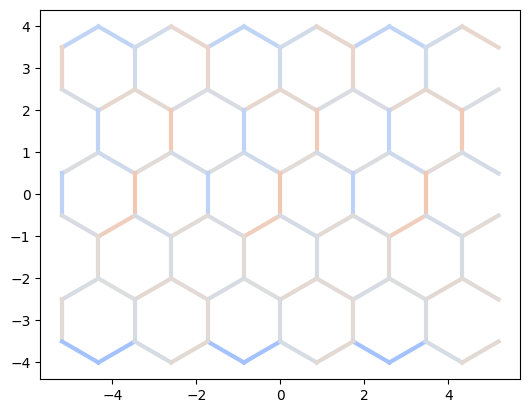

In [39]:
state1 = np.zeros(34)
for i in range(2**10):
    state1 += vis_basis(states[i])*np.abs(sorted_vecs[0,i])**2

plotter(state1)

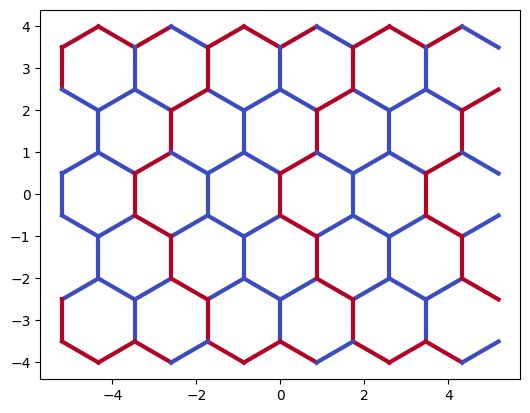

In [ ]:
plotter(vis_basis(states[939]))

In [ ]:
tmat = np.stack(vecs)

state2 = np.zeros(2**10)
state2[939] = 1

state2_decomp = np.matvec(tmat, state2)